In [1]:
import numpy as np
import pandas as pd
import torch
import sys
import os

sys.path.insert(1, '../util/')
import preprocessing_util as util

In [2]:
def preprocess(data_dir, dest_dir, final_dimensions=[400,400,400], resample_resolution=[2,2,2]):
    train_images_dir = os.path.join(data_dir, 'train_images/')
    train_label_coordinates_dir = os.path.join(data_dir, 'train_label_coordinates.csv')
    train_series_descriptions_dir = os.path.join(data_dir, 'train_series_descriptions.csv')
    train_labels_dir = os.path.join(data_dir, 'train.csv')
    
    studies = os.listdir(train_images_dir)
    
    dest_data_dir = os.path.join(dest_dir, f'resampled-{resample_resolution[0]}mm_resolution')
    if not os.path.exists(dest_data_dir):
        os.makedirs(dest_data_dir)
    
    for study in studies:
    # for study in ['2780669808']:
        series_ids = os.listdir(os.path.join(train_images_dir, study))
        
        # Get the Severity Label data for this study (one-hot encoded)
        labels = util.load_label_data(train_labels_dir, study)
        
        for series in series_ids:
        # for series in ['2149514139']:
            scan = util.load_sample(train_images_dir, study, series)
            
            # Skip this series if it has an error
            if not util.check_valid_scan(scan) :
                print(f'Skipping study {study} series {series}, multiple scans dumped in same directory')
                continue

            # Get the coordinate data for this series
            coord_data, coordinate_data_mask = util.load_coord_data(train_label_coordinates_dir, int(series))

            # Stack the scan together
            slices = np.stack([s.pixel_array for s in scan], dtype=np.float32)
            
            # Resample the Images and Coordinates to new resolution
            resampled_image, resampled_coord_data, new_spacing = util.resample_with_coordinates( slices , scan, coord_data, resample_resolution)
            
            # Transform Sagittal data to Axial Plane
            # orientation = util.get_series_orientation(train_series_descriptions_dir, int(series))
            # if 'sagittal' in orientation.lower():
            #     resampled_image, resampled_coord_data = util.sagittal_to_axial(resampled_image, resampled_coord_data)
            
            resampled_coord_data = np.array(resampled_coord_data, dtype=np.float32)
            
            #--------------------------
            # Cropping will be done during data augmentation at runtime. Leaving this all here for now to clean later
            #--------------------------
            
            # crop / zero-pad data
            # cropped_image, dim_diffs = util.crop_or_pad_image(resampled_image, final_dimensions)
            
            # dim_adjustments = [dim[0] for dim in dim_diffs]
            # cropped_coords, in_bounds_coords_mask = util.adjust_coordinates(resampled_coord_data, dim_adjustments, final_dimensions)
            
            # OOB_coords = [ data_mask == 1 and bounds_mask == 0 for data_mask, bounds_mask in zip(coordinate_data_mask, in_bounds_coords_mask)]
            # for clo in np.array(util.condition_level_order)[OOB_coords]:
            #     print(f'series {series} {clo} Out of Bounds after cropping')
            
            #--------------------------

            # combine masks
            mask = coordinate_data_mask #* in_bounds_coords_mask
            
            # Mask the labels to only predict labels that this scan determines
            assert labels.shape[0] == 25
            series_label_data = [ [0,0,0,1] if mask[i] == 0 else labels[i] for i in range(25)]
            series_label_data = np.array(series_label_data)
            
            #Exports: image, coordinates, labels, mask
            
            if not os.path.exists(os.path.join(dest_data_dir, study)):
                os.makedirs(os.path.join(dest_data_dir, study))
            if not os.path.exists(os.path.join(dest_data_dir, study, series)):
                os.makedirs(os.path.join(dest_data_dir, study, series))
            
            export_dest = os.path.join(dest_data_dir, study, series)
            
            assert type(resampled_image) == np.ndarray
            assert type(resampled_coord_data) == np.ndarray
            assert type(series_label_data) == np.ndarray
            assert type(mask) == np.ndarray
            np.save(os.path.join(export_dest,f'{series}_image.npy'), resampled_image)
            np.save(os.path.join(export_dest,f'{series}_coordinates.npy'), resampled_coord_data)
            np.save(os.path.join(export_dest,f'{series}_labels.npy'), series_label_data)
            np.save(os.path.join(export_dest,f'{series}_mask.npy'), mask)
    return


In [3]:
data_dir = '../data/'
dest_dir = '../preprocessing/datasets/'

preprocess(data_dir, dest_dir, final_dimensions=[300,300,300], resample_resolution=[1.0,1.0,1.0])
preprocess(data_dir, dest_dir, final_dimensions=[300,300,300], resample_resolution=[1.5,1.5,1.5])
preprocess(data_dir, dest_dir, final_dimensions=[300,300,300], resample_resolution=[2.0,2.0,2.0])
preprocess(data_dir, dest_dir, final_dimensions=[300,300,300], resample_resolution=[2.5,2.5,2.5])
preprocess(data_dir, dest_dir, final_dimensions=[300,300,300], resample_resolution=[3.0,3.0,3.0])



Skipping study 114899184 series 1364910156, multiple scans dumped in same directory
Skipping study 1258848546 series 178314290, multiple scans dumped in same directory
Skipping study 1271819130 series 396937199, multiple scans dumped in same directory
Skipping study 1537608176 series 2603019387, multiple scans dumped in same directory
Skipping study 1538136131 series 533252904, multiple scans dumped in same directory
Skipping study 1603568458 series 3451074679, multiple scans dumped in same directory
Skipping study 1973833645 series 1328374636, multiple scans dumped in same directory
Skipping study 1992037544 series 2051789894, multiple scans dumped in same directory
Skipping study 1995123254 series 1133656256, multiple scans dumped in same directory
Skipping study 2083466060 series 2440822236, multiple scans dumped in same directory
Skipping study 2334206006 series 4191635045, multiple scans dumped in same directory
Skipping study 2470505035 series 1297079442, multiple scans dumped in

In [1]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure, morphology
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt

sys.path.insert(1, '../util/')
import preprocessing_util as util
import augmentation as aug


def plot_3d(image, threshold=-300):
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, normals, values = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [38]:
def plot_roi(volume, coords, idx=0):
    coord = coords[idx]
    # print(coord[0])
    img = volume[:,int(coord[1]),:]
    plt.imshow(img, cmap=plt.cm.bone)
    plt.scatter(x=[coord[2]], y=[coord[0]], c='r', s=40)
    plt.show()

In [3]:
volume = np.load('datasets/resampled-2.0mm_resolution/4003253/2448190387/2448190387_image.npy')
coords = np.load('datasets/resampled-2.0mm_resolution/4003253/2448190387/2448190387_coordinates.npy')
print(volume[0,40:,:])
volume = aug.normalize_volume(volume)
print(volume[0,40:,:])

[[ 4.2738225e-15  3.5986481e+01  4.2925262e+01 ...  1.9456320e+02
   1.8161674e+02  1.1844031e-13]
 [ 5.6844534e-15  4.8626568e+01  3.7875835e+01 ...  1.7346207e+02
   2.1686095e+02  1.3138594e-15]
 [ 7.0160010e-15  6.8779480e+01  6.7333176e+01 ...  1.9498898e+02
   2.1991272e+02  1.2576430e-16]
 ...
 [ 2.9476012e-20  6.7156000e-04 -8.4069066e-02 ... -2.2176361e-02
   1.4394253e-04 -4.0799485e-20]
 [ 2.2227432e-21 -6.5639242e-06  8.2170311e-04 ...  2.1675494e-04
  -1.4069150e-06  2.0773034e-20]
 [ 2.7468379e-22  1.0425366e-20 -1.7271122e-20 ... -8.6898676e-21
   2.4331813e-20 -4.9109942e-23]]
[[-0.754095   -0.419867   -0.35542238 ...  1.0529301   0.9326886
  -0.754095  ]
 [-0.754095   -0.30247092 -0.40231943 ...  0.8569512   1.2600226
  -0.754095  ]
 [-0.754095   -0.11529876 -0.12873144 ...  1.0568845   1.2883662
  -0.754095  ]
 ...
 [-0.754095   -0.75408876 -0.75487584 ... -0.754301   -0.75409365
  -0.754095  ]
 [-0.754095   -0.7540951  -0.7540874  ... -0.75409305 -0.754095
  -0.75409

In [4]:
# rotated_volume = aug.random_rotation(volume, [[0,0,0]], 10)
scaled_volume, scaled_coords = aug.random_scaling(volume, coords, 0.2)

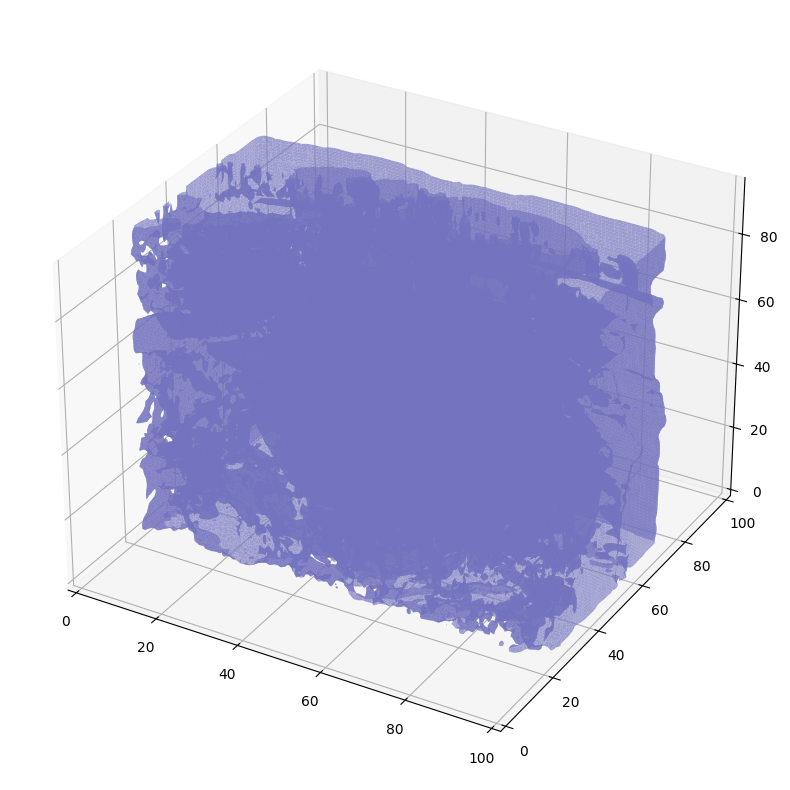

In [36]:
plot_3d(volume, 70)

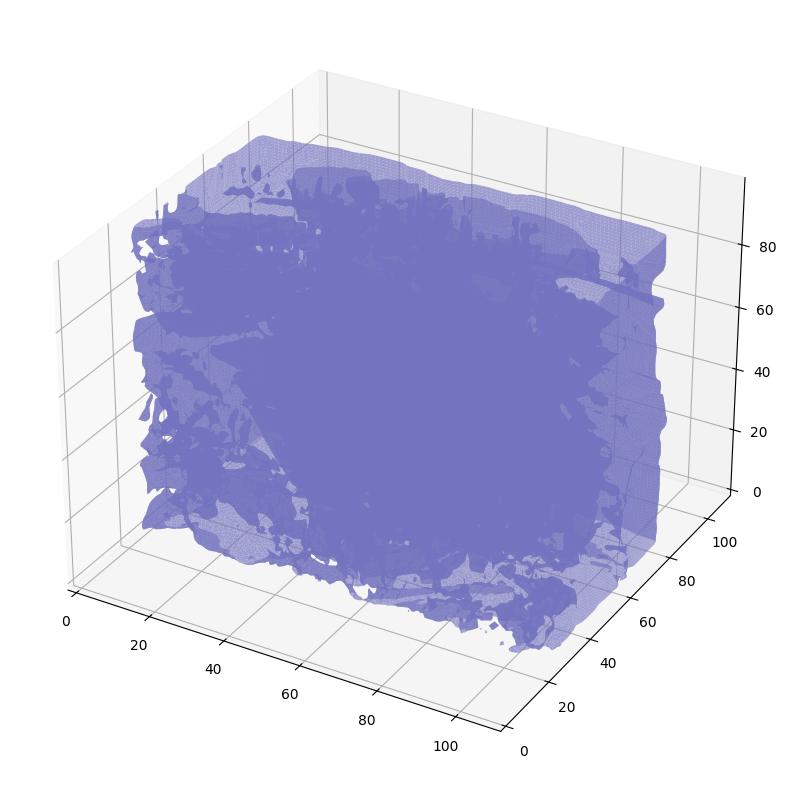

In [37]:
plot_3d(scaled_volume, 70)

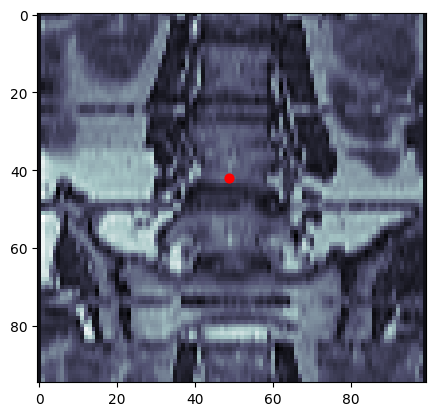

In [39]:
plot_roi(volume, coords, 17)

(25, 3)
1
[18.6279068  70.97701645 25.38610077]


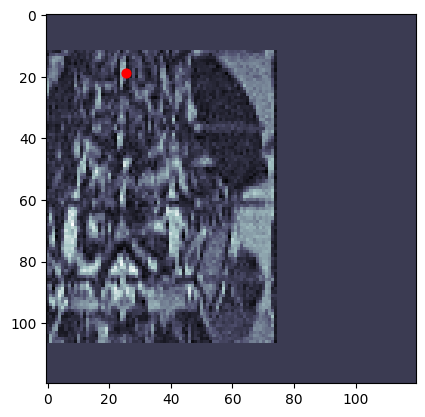

In [84]:
scaled_volume, scaled_coords = aug.random_scaling(volume, coords, 0)
noised_volume = aug.gaussian_noise(scaled_volume, 0.2)

new_shape=[120,120,120]
max_shift = 35
cropped_volume, cropped_coords, mask = aug.random_shift_and_crop(noised_volume, scaled_coords, new_shape, max_shift)
print(cropped_coords.shape)
cropped_coords = cropped_coords * mask[:, np.newaxis]

n = 20
print(mask[n])
print(cropped_coords[n])
plot_roi(cropped_volume, cropped_coords, n)


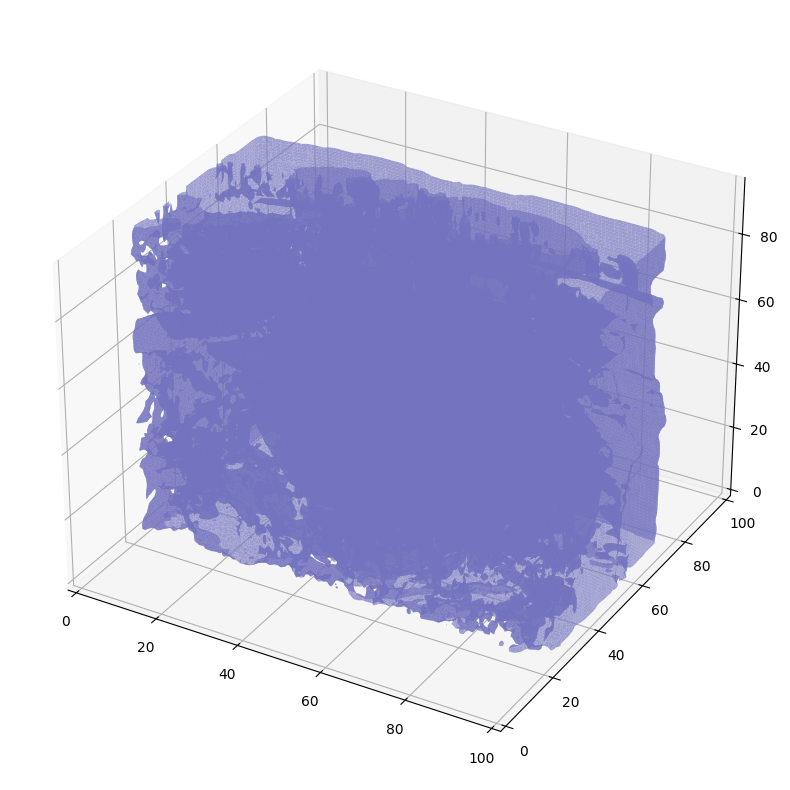

In [23]:
plot_3d(np.load('datasets/resampled-2.0mm_resolution/4003253/2448190387/2448190387_image.npy'), 70)

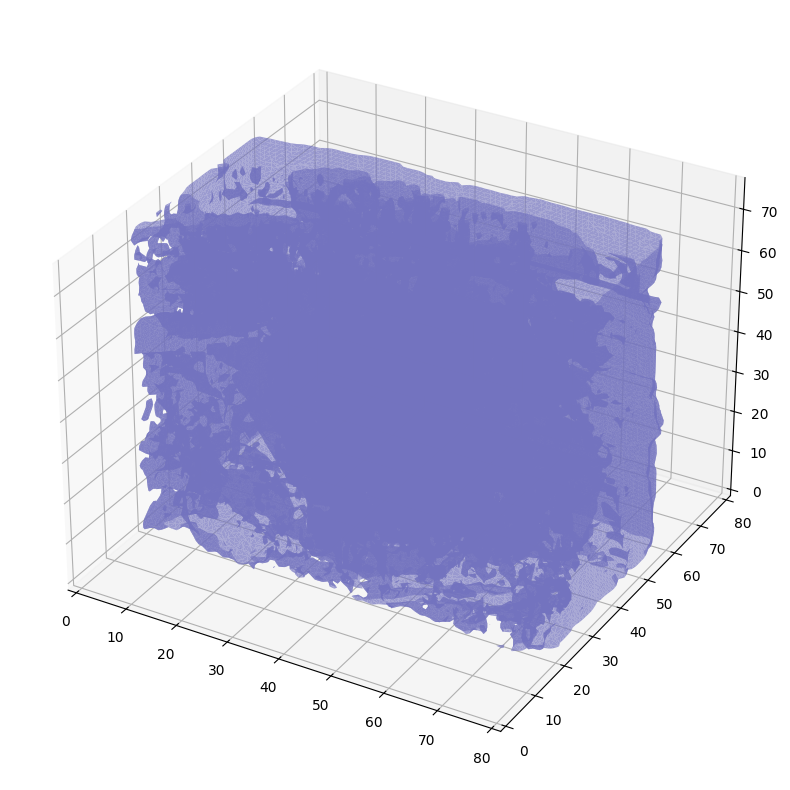

In [24]:
plot_3d(np.load('datasets/resampled-2.5mm_resolution/4003253/2448190387/2448190387_image.npy'), 70)

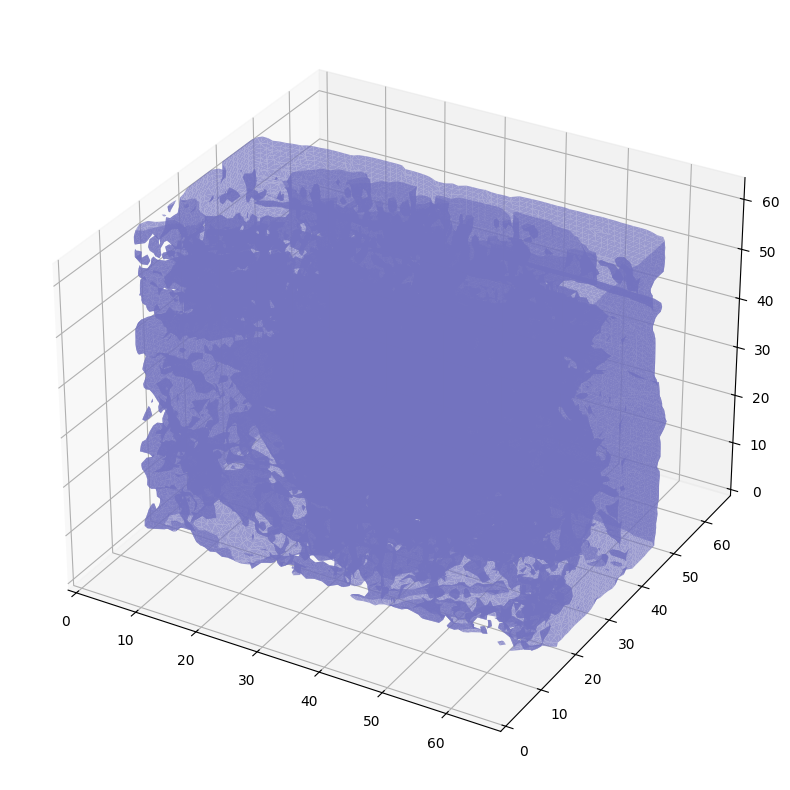

In [25]:
plot_3d(np.load('datasets/resampled-3.0mm_resolution/4003253/2448190387/2448190387_image.npy'), 70)